## Testing clustering algorithms for anomaly detection
FastMapSVM is an interpretable machine learning framework for classifying complex objects, combining the complementary strengths of FastMap with support vector machines (SVMs). Fastmap projects the solution into a lower-dimensional space which can be used for clustering and anomaly detection.

Code: https://github.com/malcolmw/FastMapSVM
Paper: https://doi.org/10.1038/s44172-023-00099-8

In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import os
import obspy
from obspy.core.utcdatetime import UTCDateTime
import matplotlib.pyplot as plt
import h5py
import seaborn as sns 
from importlib import reload;

import fastmap
import sklearn
from sklearn.pipeline import Pipeline
import test_performances as tp

Importing fastmap.core


## Load data

In [90]:
reload(tp)

root_dir = '/projects/infrasound/data/infrasound/2023_ML_balloon/data/'
dataset_name = 'minibooster'
dataset_validation_name = 'minibooster'
h5_file  = f'all_waveform_dataset_{dataset_name}_0.015Hz.h5'
sampling_X_total = 5.
X_total, labels_all, windows_all, event_types_all, ids_all, section_ids_all = tp.load_data(root_dir, h5_file, normalize_type='none')

In [91]:
max_id = 3100
X_total = X_total[:max_id]
labels_all = labels_all[:max_id]
windows_all = windows_all[:max_id]
event_types_all = event_types_all[:max_id]
ids_all = ids_all[:max_id]
section_ids_all = section_ids_all[:max_id]

## Test/train split

In [92]:
reload(tp)

perc_train = 0.7
idx_train, idx_test = tp.find_splits(X_total.shape[0], perc_train=0.7)

## Load seismic infrasound data

In [152]:
reload(tp)

file = '/projects/infrasound/data/infrasound/2023_ML_balloon/data/data_alaska/ev_2020-10-19T20_Mw7.6.mseed'
st_real = tp.load_real_data(file, nmax=10, freqmin=0.15, freqmax=2.5, tmin=340., tmax=503.)

In [94]:
reload(tp)

## Number of synthetic waveforms
perc_pert = 1.5
n_pert = int((perc_pert/100.)*X_total.shape[0])

## Discretization
dists = np.arange(1., 5., 0.01)[:] # in degrees
depths = np.linspace(10e3, 30e3, 500)
period_stf = np.linspace(1., 20., 100)
DISTS, DEPTHS, PERIODS = np.meshgrid(dists, depths, period_stf)
DISTS, DEPTHS, PERIODS = DISTS.ravel(), DEPTHS.ravel(), PERIODS.ravel()
idx = np.random.randint(0, DISTS.size, n_pert)
DISTS, DEPTHS, PERIODS = DISTS[idx], DEPTHS[idx], PERIODS[idx]

## STF
#period = 10
#stf = gf.BoxcarSTF(period, anchor=0.)
#stf = None

## Greens functions STORES
base_folder = '/projects/infrasound/data/infrasound/2023_Venus_inversion/'
store_id = 'GF_venus_small'

st_real = tp.build_synthetic_traces(DISTS, DEPTHS, PERIODS, base_folder, store_id, freqmin=0.15, freqmax=2.5, offset_trim_begin=40., offset_trim_end=140.)

In [153]:
reload(tp)

SNRs = [4.5]
X_total_SNR, perturbed_idx_SNR, pert_corresponding_input_SNR = tp.build_perturbed_dataset_SNRs(SNRs, X_total, section_ids_all, st_real, sampling_X_total, offset_end_max=20., seed=10)

In [263]:
sig_times = dict(
    #B2HI = [UTCDateTime("2020-08-20T05:44:23.000000Z"), UTCDateTime("2020-08-20T13:04:23.000000Z")],
    B1HI = [UTCDateTime("2020-08-20T06:30")+289.5, UTCDateTime("2020-08-20T06:30")+291.5],
    B2LO = [UTCDateTime("2020-08-20T06:30")+265.5, UTCDateTime("2020-08-20T06:30")+266.5],
    #B3HI = [UTCDateTime("2020-08-20T05:27:50.000000Z"), UTCDateTime("2020-08-20T07:56:10.000000Z")],
    #B3LO = [UTCDateTime("2020-08-20T05:50:54.000000Z"), UTCDateTime("2020-08-20T10:09:14.000000Z")]
)
#[2847 1514 1516]
new_idx = []
for iwindow, (window, id) in enumerate(zip(windows_all, ids_all)):
    #np.r_[perturbed_idx_SNR[4.5], 1000]
    start, end = UTCDateTime(window[0]), UTCDateTime(window[1])
    print(id.decode())
    for key, sigs in sig_times.items():
        if key in id.decode():
            if (sigs[0] >= start and sigs[0] <= end) or (sigs[1] >= start and sigs[1] <= end) or (sigs[0] <= start and sigs[1] >= end) or (sigs[0] >= start and sigs[1] <= end):
                #print(key, id.decode())
                new_idx.append(iwindow)
            break

B1HI-0
B1HI-1
B1HI-2
B1HI-3
B1HI-4
B1HI-5
B1HI-6
B1HI-7
B1HI-8
B1HI-9
B1HI-10
B1HI-11
B1HI-12
B1HI-13
B1HI-14
B1HI-15
B1HI-16
B1HI-17
B1HI-18
B1HI-19
B1HI-20
B1HI-21
B1HI-22
B1HI-23
B1HI-24
B1HI-25
B1HI-26
B1HI-27
B1HI-28
B1HI-29
B1HI-30
B1HI-31
B1HI-32
B1HI-33
B1HI-34
B1HI-35
B1HI-36
B1HI-37
B1HI-38
B1HI-39
B1HI-40
B1HI-41
B1HI-42
B1HI-43
B1HI-44
B1HI-45
B1HI-46
B1HI-47
B1HI-48
B1HI-49
B1HI-50
B1HI-51
B1HI-52
B1HI-53
B1HI-54
B1HI-55
B1HI-56
B1HI-57
B1HI-58
B1HI-59
B1HI-60
B1HI-61
B1HI-62
B1HI-63
B1HI-64
B1HI-65
B1HI-66
B1HI-67
B1HI-68
B1HI-69
B1HI-70
B1HI-71
B1HI-72
B1HI-73
B1HI-74
B1HI-75
B1HI-76
B1HI-77
B1HI-78
B1HI-79
B1HI-80
B1HI-81
B1HI-82
B1HI-83
B1HI-84
B1HI-85
B1HI-86
B1HI-87
B1HI-88
B1HI-89
B1HI-90
B1HI-91
B1HI-92
B1HI-93
B1HI-94
B1HI-95
B1HI-96
B1HI-97
B1HI-98
B1HI-99
B1HI-100
B1HI-101
B1HI-102
B1HI-103
B1HI-104
B1HI-105
B1HI-106
B1HI-107
B1HI-108
B1HI-109
B1HI-110
B1HI-111
B1HI-112
B1HI-113
B1HI-114
B1HI-115
B1HI-116
B1HI-117
B1HI-118
B1HI-119
B1HI-120
B1HI-121
B1HI-122
B1H

B2HI-1736
B2HI-1737
B2HI-1738
B2HI-1739
B2HI-1740
B2HI-1741
B2HI-1742
B2HI-1743
B2HI-1744
B2HI-1745
B2HI-1746
B2HI-1747
B2HI-1748
B2HI-1749
B2HI-1750
B2HI-1751
B2HI-1752
B2HI-1753
B2HI-1754
B2HI-1755
B2HI-1756
B2HI-1757
B2HI-1758
B2HI-1759
B2HI-1760
B2HI-1761
B2HI-1762
B2HI-1763
B2HI-1764
B2HI-1765
B2HI-1766
B2HI-1767
B2HI-1768
B2HI-1769
B2HI-1770
B2HI-1771
B2HI-1772
B2HI-1773
B2HI-1774
B2HI-1775
B2HI-1776
B2HI-1777
B2HI-1778
B2HI-1779
B2HI-1780
B2HI-1781
B2HI-1782
B2HI-1783
B2HI-1784
B2HI-1785
B2HI-1786
B2HI-1787
B2HI-1788
B2HI-1789
B2HI-1790
B2HI-1791
B2HI-1792
B2HI-1793
B2HI-1794
B2HI-1795
B2HI-1796
B2HI-1797
B2HI-1798
B2HI-1799
B2HI-1800
B2HI-1801
B2HI-1802
B2HI-1803
B2HI-1804
B2HI-1805
B2HI-1806
B2HI-1807
B2HI-1808
B2HI-1809
B2HI-1810
B2HI-1811
B2HI-1812
B2HI-1813
B2HI-1814
B2HI-1815
B2HI-1816
B2HI-1817
B2HI-1818
B2HI-1819
B2HI-1820
B2HI-1821
B2HI-1822
B2HI-1823
B2HI-1824
B2HI-1825
B2HI-1826
B2HI-1827
B2HI-1828
B2HI-1829
B2HI-1830
B2HI-1831
B2HI-1832
B2HI-1833
B2HI-1834
B2HI-1835


B2LO-2675
B2LO-2676
B2LO-2677
B2LO-2678
B2LO-2679
B2LO-2680
B2LO-2681
B2LO-2682
B2LO-2683
B2LO-2684
B2LO-2685
B2LO-2686
B2LO-2687
B2LO-2688
B2LO-2689
B2LO-2690
B2LO-2691
B2LO-2692
B2LO-2693
B2LO-2694
B2LO-2695
B2LO-2696
B2LO-2697
B2LO-2698
B2LO-2699
B2LO-2700
B2LO-2701
B2LO-2702
B2LO-2703
B2LO-2704
B2LO-2705
B2LO-2706
B2LO-2707
B2LO-2708
B2LO-2709
B2LO-2710
B2LO-2711
B2LO-2712
B2LO-2713
B2LO-2714
B2LO-2715
B2LO-2716
B2LO-2717
B2LO-2718
B2LO-2719
B2LO-2720
B2LO-2721
B2LO-2722
B2LO-2723
B2LO-2724
B2LO-2725
B2LO-2726
B2LO-2727
B2LO-2728
B2LO-2729
B2LO-2730
B2LO-2731
B2LO-2732
B2LO-2733
B2LO-2734
B2LO-2735
B2LO-2736
B2LO-2737
B2LO-2738
B2LO-2739
B2LO-2740
B2LO-2741
B2LO-2742
B2LO-2743
B2LO-2744
B2LO-2745
B2LO-2746
B2LO-2747
B2LO-2748
B2LO-2749
B2LO-2750
B2LO-2751
B2LO-2752
B2LO-2753
B2LO-2754
B2LO-2755
B2LO-2756
B2LO-2757
B2LO-2758
B2LO-2759
B2LO-2760
B2LO-2761
B2LO-2762
B2LO-2763
B2LO-2764
B2LO-2765
B2LO-2766
B2LO-2767
B2LO-2768
B2LO-2769
B2LO-2770
B2LO-2771
B2LO-2772
B2LO-2773
B2LO-2774


In [256]:
for SNR, perturbed_idx in perturbed_idx_SNR.items():
    perturbed_idx_SNR[SNR] += new_idx

In [262]:
perturbed_idx_SNR

{4.5: [527,
  528,
  529,
  733,
  734,
  735,
  2150,
  2151,
  490,
  491,
  492,
  371,
  372,
  2503,
  2504,
  2505,
  2704,
  2705,
  2706,
  2848,
  2849,
  2850,
  1585,
  1586,
  1587,
  1514,
  1515,
  1516,
  2845,
  2846,
  2847,
  2848,
  2849,
  2850,
  2851,
  2852,
  2853,
  2854,
  2855,
  2856,
  2857,
  2858,
  2859,
  2860,
  2861,
  2862,
  2863,
  2864,
  2865,
  2866,
  2867,
  2868,
  2869,
  2870,
  2871,
  2872,
  2873,
  2874,
  2875,
  2876,
  2877,
  2878,
  2879,
  2880,
  2881,
  2882,
  2883,
  2884,
  2885,
  2886,
  2887,
  2888,
  2889,
  2890,
  2891,
  2892,
  2893,
  2894,
  2895,
  2896,
  2897,
  2898,
  2899,
  2900,
  2901,
  2902,
  2903,
  2904,
  2905,
  2906,
  2907,
  2908,
  2909,
  2910,
  2911,
  2912,
  2913,
  2914,
  2915,
  2916,
  2917,
  2918,
  2919,
  2920,
  2921,
  2922,
  2923,
  2924,
  2925,
  2926,
  2927,
  2928,
  2929,
  2930,
  2931,
  2932,
  2933,
  2934,
  2935,
  2936,
  2937,
  2938,
  2939,
  2940,
  2941,
  2942

## STA/LTA

In [154]:
reload(tp)

sta_lta_signal_pert_SNR, sta_lta_signal = tp.compute_sta_lta(X_total, X_total_SNR, sampling_X_total, section_ids_all, sta=1., lta=50.)

## Normalization

In [155]:
reload(tp)

X_total_SNR = tp.normalization(X_total_SNR)

## Data visualization

<IPython.core.display.Javascript object>


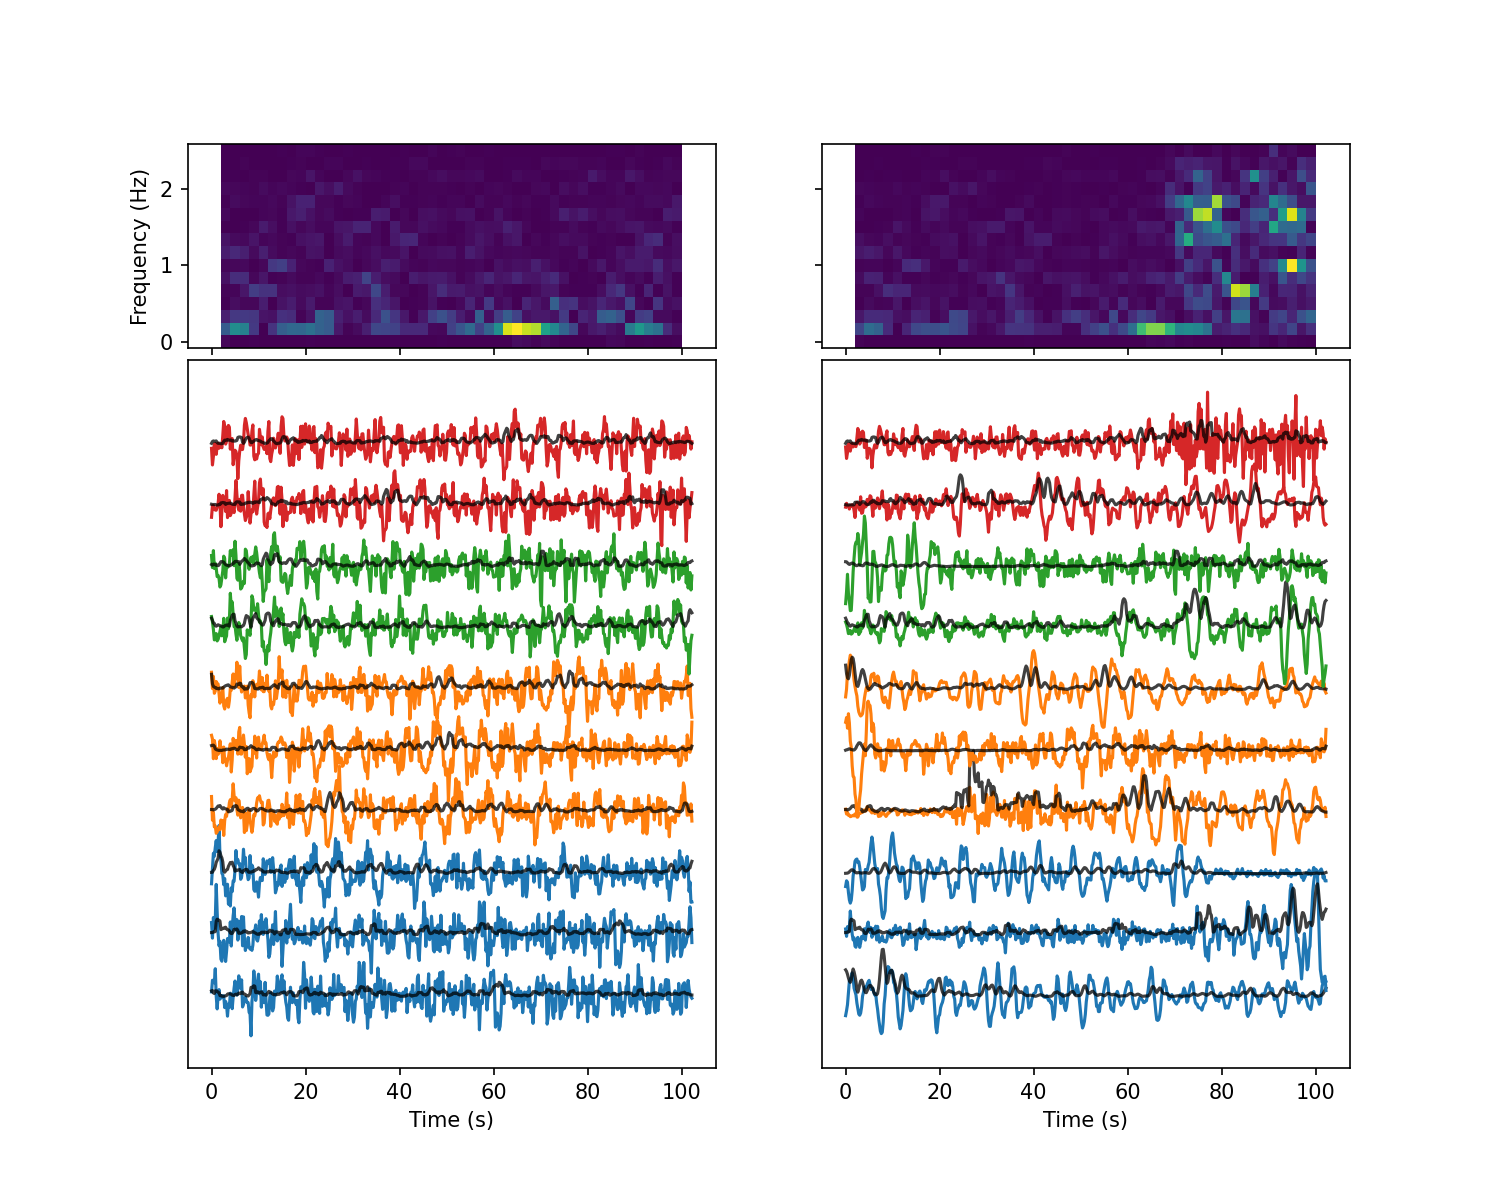

In [156]:
reload(tp)
        
SNR = [SNR for SNR in X_total_SNR.keys()][0]
X_total_loc = X_total_SNR[SNR]
perturbed_idx_loc = perturbed_idx_SNR[SNR]
pert_corresponding_input_loc = pert_corresponding_input_SNR[SNR]
sta_lta_signal_loc = sta_lta_signal_pert_SNR[SNR]

tp.plot_pert_dataset(X_total, X_total_loc, sta_lta_signal_loc, sta_lta_signal, perturbed_idx_loc, pert_corresponding_input_loc, sampling_X_total, factor_spectro=3)

## Feature extraction - tsfresh

In [157]:
reload(tp)

extracted_features_SNR = tp.extract_features_SNRs(X_total_SNR, sampling_X_total)

Feature Extraction: 100%|██████████| 50/50 [05:38<00:00,  6.77s/it]


## Best feature selection over testing dataset

In [257]:
reload(tp)

n_features = 50
reference_SNR = [SNR for SNR in X_total_SNR.keys()][0]
n_inputs = X_total_SNR[reference_SNR].shape[0]
relevance_table_SNR, best_features = tp.compute_best_features(perturbed_idx_SNR, idx_train, extracted_features_SNR, reference_SNR, n_inputs, n_features, plot=False)

['pressure__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2'
 'pressure__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2'
 'pressure__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2'
 'pressure__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0'
 'pressure__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0'
 'pressure__approximate_entropy__m_2__r_0.3'
 'pressure__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0'
 'pressure__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.4'
 'pressure__sample_entropy'
 'pressure__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2'
 'pressure__approximate_entropy__m_2__r_0.5'
 'pressure__spkt_welch_density__coeff_5'
 'pressure__lempel_ziv_complexity__bins_3'
 'pressure__lempel_ziv_complexity__bins_5'
 'pressure__lempel_ziv_complexity__bins_10'
 'pressure__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2'
 'pressure__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__q

## Model setup

In [258]:
reload(tp)

method = 'autoencoder'
method = 'copod'
#method = 'ecod'
#method = 'IForest'
#method = 'lof'
add_STA_LTA = False
contamination = 0.025
max_samples = 'auto'
n_estimators = 100

X_in, X_test = tp.get_training_testing_data(idx_train, idx_test, extracted_features_SNR[SNR], X_total_SNR[SNR], best_features, method)
fastmapsvm, scores, scores_test = tp.return_model_and_scores(method, X_in, X_test, add_STA_LTA, contamination, max_samples, n_estimators, seed=50)

## Compute ROC curves

In [259]:
reload(tp)

thresholds = np.linspace(np.quantile(scores, q=0.01), np.quantile(scores, q=0.99), 200)
performances = tp.compute_performances(idx_train, idx_test, perturbed_idx_SNR[SNR], scores, scores_test, thresholds, method)

100%|██████████| 200/200 [00:00<00:00, 377.61it/s]


In [260]:
sta_lta_max_train = sta_lta_signal_pert_SNR[SNR][idx_train,:,0].max(axis=1)
sta_lta_max_test = sta_lta_signal_pert_SNR[SNR][idx_test,:,0].max(axis=1)
thresholds = np.linspace(np.quantile(sta_lta_max_train, q=0.01), np.quantile(sta_lta_max_train, q=0.99), 200)
performances_sta_lta = tp.compute_performances(idx_train, idx_test, perturbed_idx_SNR[SNR], sta_lta_max_train, sta_lta_max_test, thresholds, 'sta_lta')

100%|██████████| 200/200 [00:00<00:00, 405.30it/s]


## Visualization

[2847 1514 1516]


/staff/quentin/miniconda2/envs/seismonpy/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


<IPython.core.display.Javascript object>


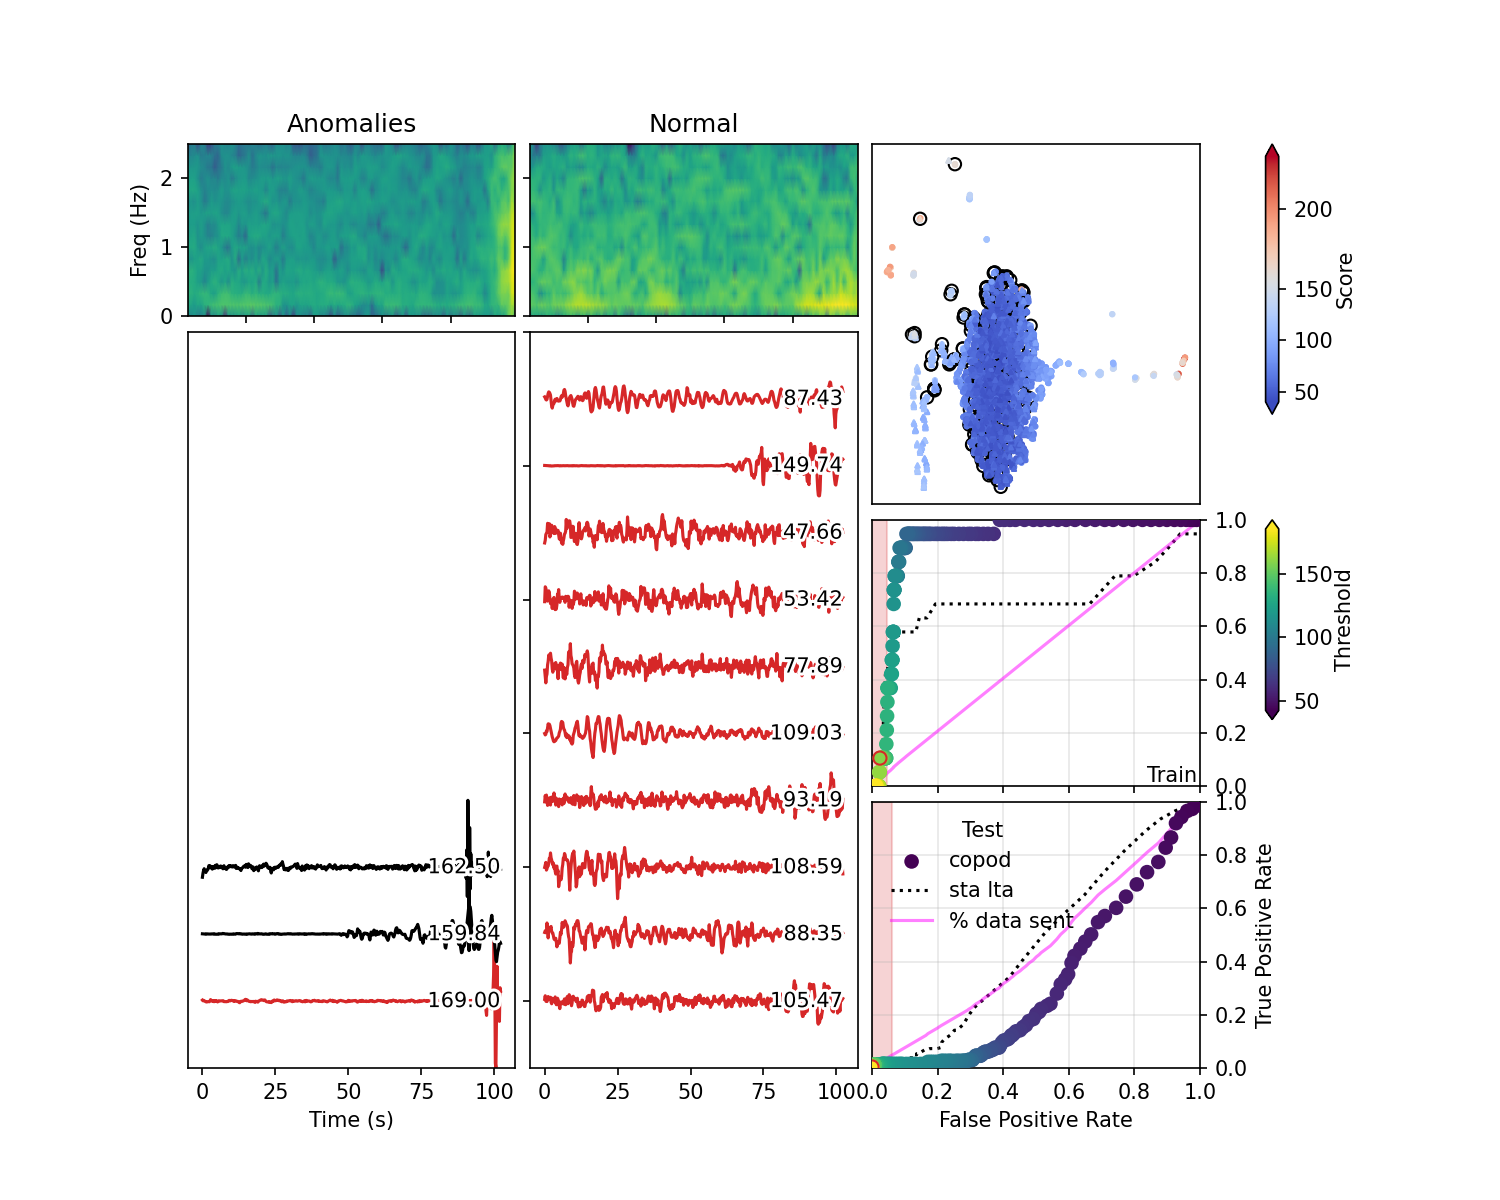

In [261]:
reload(tp)
        
waveforms_all = X_total_SNR[SNR][:,:,0]
threshold = None
file_figure = f'./figures/performances_{method}_{dataset_name}_{dataset_validation_name}_SNR{SNR}.pdf'
tp.plot_performances(file_figure, waveforms_all, perturbed_idx_SNR[SNR], idx_train, idx_test, performances, X_in, X_test, scores, scores_test, sampling_X_total, method, fastmapsvm, performances_sta_lta=performances_sta_lta, max_waveforms=10, threshold=threshold)

## Old codes

In [21]:
from matplotlib import colors
from sklearn.manifold import TSNE
if method in ['isolation_forest',]:
    divnorm=colors.TwoSlopeNorm(vmin=scores.min(), vcenter=0., vmax=scores.max())
elif method in ['ecod',]:
    divnorm=colors.TwoSlopeNorm(vmin=0., vcenter=0.5, vmax=1.)
else:
    divnorm=colors.TwoSlopeNorm(vmin=scores.min(), vcenter=0.5, vmax=scores.max())

# Compute the embedding of the train data
W_all = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=3).fit_transform(np.r_[X_in,X_test])
W_total = W_all[:X_in.shape[0]]
W_test = W_all[X_in.shape[0]:]

idx_pert_all = perturbed_idx_SNR[SNR]
intersection_values = np.intersect1d(idx_pert_all, idx_train)
idx_pert = np.nonzero(np.in1d(idx_train, intersection_values))[0]

intersection_values = np.intersect1d(idx_pert_all, idx_test)
idx_pert_test = np.nonzero(np.in1d(idx_test, intersection_values))[0]

plt.close('all')

fig = plt.figure(figsize=(7,5))
grid = fig.add_gridspec(1, 2)

ax = fig.add_subplot(grid[0,0])
sc = ax.scatter(W_total[:, 0], W_total[:, 1], s=4, c=scores, cmap='coolwarm', norm=divnorm, zorder=10)
plt.colorbar(sc)
#sc = ax.scatter(W_total[idx_pert, 0], W_total[idx_pert, 1], s=20, c=isolation[idx_pert], cmap='coolwarm', norm=divnorm, zorder=1)
sc = ax.scatter(W_total[idx_pert,0], W_total[idx_pert,1], facecolor=None, edgecolor='black', s=35)
sc.set_facecolor("none")
ax.set_xlabel('$w_0$')
ax.set_ylabel('$w_1$')

ax = fig.add_subplot(grid[0,1], sharex=ax, sharey=ax)
sc = ax.scatter(W_test[:, 0], W_test[:, 1], s=4, c=scores_test, cmap='coolwarm', norm=divnorm, zorder=10)
plt.colorbar(sc)
sc = ax.scatter(W_test[idx_pert_test,0], W_test[idx_pert_test,1], facecolor=None, edgecolor='black', s=35)
sc.set_facecolor("none")
ax.set_xlabel('$w_0$')
ax.set_ylabel('$w_1$')

ValueError: vmin, vcenter, and vmax must be in ascending order

In [ ]:
from scipy.signal import spectrogram
from matplotlib import patheffects
path_effects = [patheffects.withStroke(linewidth=3, foreground="w")]

def plot_results(X_total_SNR, sampling_X_total, SNR, perturbed_idx_SNR, isolation, isolation_forest, scores, min_n_plot=15):

    idx_pert = np.array(perturbed_idx_SNR[SNR])
    labels = np.zeros(X_total_SNR[SNR].shape[0], dtype=int)
    labels[idx_pert] = 1

    sampling_freq = sampling_X_total
    times = np.arange(X_total.shape[1])/sampling_freq

    sortedidx = np.argsort(scores)
    isolation_sorted = isolation[sortedidx]
    scores_sorted = scores[sortedidx]
    X_sorted = np.transpose(X_total_SNR[SNR][sortedidx,:], (0,2,1))
    labels_new_sorted = labels[sortedidx]

    idx_pert_sorted = np.array([np.where(sortedidx==idx)[0][0] for idx in idx_pert])
    
    #idx_train_sorted = sortedidx[idx_train]
    #labels_train_sorted = labels_new[idx_train_sorted]

    W = W_total[sortedidx,:2]#fastmapsvm[0].transform(X_sorted)
    if isolation_forest:
        idx_anomaly = np.where(isolation_sorted==-1)[0]
        idx_normal = np.where(isolation_sorted==1)[0]
        #idx_pert_in_anomaly = np.where(labels_new_sorted[idx_anomaly]==1)[0] ## Problem here?
        #idx_pert_in_normal = np.where(labels_new_sorted[idx_normal]==1)[0]
        idx_pert_in_anomaly = np.intersect1d(idx_pert_sorted, idx_anomaly)
        idx_pert_in_normal = np.intersect1d(idx_pert_sorted, idx_normal)

    else:
        idx_anomaly = np.where(isolation_sorted==1)[0]
        idx_normal = np.where(isolation_sorted==0)[0]
        idx_pert_in_anomaly = np.intersect1d(idx_pert_sorted, idx_anomaly)#np.where(labels_new_sorted[idx_anomaly]==1)[0]
        idx_pert_in_normal = np.intersect1d(idx_pert_sorted, idx_normal)#np.where(labels_new_sorted[idx_normal]==1)[0]

        idx_test_sorted = sortedidx[idx_test]
        idx_pert_in_test_sorted = np.intersect1d(idx_pert_sorted, idx_test_sorted)
        idx_anomaly_test = np.intersect1d(idx_anomaly, idx_test_sorted)
        idx_normal_test = np.intersect1d(idx_normal, idx_test_sorted)
        idx_pert_in_anomaly_test = np.intersect1d(idx_pert_sorted, idx_anomaly_test)
        idx_pert_in_normal_test = np.intersect1d(idx_pert_sorted, idx_normal_test)

        idx_train_sorted = sortedidx[idx_train]
        idx_pert_in_train_sorted = np.intersect1d(idx_pert_sorted, idx_train_sorted)
        idx_anomaly_train = np.intersect1d(idx_anomaly, idx_train_sorted)
        idx_normal_train = np.intersect1d(idx_normal, idx_train_sorted)
        idx_pert_in_anomaly_train = np.intersect1d(idx_pert_sorted, idx_anomaly_train)
        idx_pert_in_normal_train = np.intersect1d(idx_pert_sorted, idx_normal_train)


        """
        flag_test_sorted = np.zeros(sortedidx.size)
        flag_test_sorted[sortedidx[idx_test]] = 1
        flag_train_sorted = np.zeros(sortedidx.size)
        flag_train_sorted[sortedidx[idx_train]] = 1

        idx_test_sorted = np.where(flag_test_sorted==1)[0]
        idx_train_sorted = np.where(flag_train_sorted==1)[0]

        idx_anomaly_test = np.intersect1d(idx_test_sorted, idx_anomaly)
        idx_normal_test = np.intersect1d(idx_test_sorted, idx_normal)
        idx_anomaly_train = np.intersect1d(idx_train_sorted, idx_anomaly)
        idx_normal_train = np.intersect1d(idx_train_sorted, idx_normal)

        idx_pert_in_test_sorted = np.intersect1d(idx_pert_sorted, idx_test_sorted)
        idx_pert_in_train_sorted = np.intersect1d(idx_pert_sorted, idx_train_sorted)

        idx_pert_in_anomaly_train = np.intersect1d(idx_pert_in_train_sorted, idx_anomaly_train)#np.where(labels_train_sorted[idx_anomaly_train]==1)[0]
        idx_pert_in_normal_train = np.intersect1d(idx_pert_in_train_sorted, idx_normal_train)#np.where(labels_train_sorted[idx_normal_train]==1)[0]
        idx_pert_in_anomaly_test = np.intersect1d(idx_pert_in_test_sorted, idx_anomaly_test)#np.where(labels_test_sorted[idx_anomaly_test]==1)[0]
        idx_pert_in_normal_test = np.intersect1d(idx_pert_in_test_sorted, idx_normal_test)#np.where(labels_test_sorted[idx_normal_test]==1)[0]
        """

    if isolation_forest:
        POS = idx_pert.size
        NEG = X_total.shape[0]-POS
        TP = len(idx_pert_in_anomaly)
        FN = len(idx_pert_in_normal)
        FP = idx_anomaly.size - len(idx_pert_in_anomaly)
        TN = idx_normal.size - FN
        print(idx_pert.size, idx_anomaly.size, idx_normal.size, len(idx_pert_in_anomaly), len(idx_pert_in_normal))
        # 72 50 450 37 31
    else:
        POS = idx_pert_in_test_sorted.size
        NEG = idx_test_sorted.size-POS
        TP = len(idx_pert_in_anomaly_test)
        FP = idx_anomaly_test.size - TP
        FN = len(idx_pert_in_normal_test)
        TN = idx_normal_test.size - FN

        POS_train = idx_pert_in_train_sorted.size
        NEG_train = idx_train_sorted.size-POS_train
        TP_train = len(idx_pert_in_anomaly_train)
        FP_train = idx_anomaly_train.size - TP_train
        FN_train = len(idx_pert_in_normal_train)
        TN_train = idx_normal_train.size - FN_train

        TPR_train = TP_train/POS_train
        TNR_train = TN_train/NEG_train
        FPR_train = FP_train/NEG_train
        FNR_train = FN_train/POS_train

    TPR = TP/POS
    TNR = TN/NEG
    FPR = FP/NEG
    FNR = FN/POS
    """
    cm = np.array([[TNR*1e2, FPR*1e2],
                   [FNR*1e2, TPR*1e2]])
    """
    
    max_s = max(idx_pert_in_anomaly.size, idx_pert_in_normal.size)
    ids = [aa for aa in idx_pert_in_anomaly]
    flag = [aa for aa in range(idx_pert_in_anomaly.size)]
    ids_normal = [aa for aa in idx_pert_in_normal]
    flag_normal = [aa for aa in range(idx_pert_in_normal.size)]
    n_to_add = max(min_n_plot, len(ids_normal))-len(ids)
    diff = np.setdiff1d(idx_anomaly, ids)
    n_to_add = min(n_to_add, diff.size)
    if n_to_add > 0:
        ids += np.random.choice(diff, n_to_add, replace=False).tolist()

    while len(ids_normal) < len(ids): 
        possible_solutions = np.setdiff1d(idx_normal, ids_normal)
        id = np.random.choice(possible_solutions)
        #if id in ids_normal:
        #    continue
        ids_normal.append(id)

    fig = plt.figure(figsize=(10,8))
    offset=1
    h_total = len(ids)+offset
    grid = fig.add_gridspec(h_total,12 )
    h_map = int(0.5*(len(ids)+offset))
    x_map = 6
    x_waveform = x_map//2

    ax_map = fig.add_subplot(grid[:h_map-1,x_map+1:])
    ax_map.set_title(f'Outliers %: {1e2*idx_anomaly.size/isolation_sorted.size:.2f}%')
    sc = ax_map.scatter(W[:, 0], W[:, 1], s=1, c=scores_sorted, cmap='coolwarm', norm=divnorm)
    cbar = plt.colorbar(sc)
    cbar.ax.set_ylabel('Score', labelpad=1., fontsize=12.)
    ax_map.set_xlabel('$w_0$')
    ax_map.set_ylabel('$w_1$')
    ax_map.tick_params(axis='both', which='both', labelleft=False, left=False, labelbottom=False, bottom=False)

    h_end = h_map
    if not isolation_forest:
        h_end = h_map//2

    ax_confusion = fig.add_subplot(grid[h_map+1:h_map+1+h_end,x_map+1:-1])
    cm = np.array([[TNR*1e2, FPR*1e2],
                   [FNR*1e2, TPR*1e2]])
    sns.heatmap(cm, annot=True, fmt='.1f', cmap="coolwarm", cbar=False, ax=ax_confusion)
    ax_confusion.set_xlabel("Predicted")
    ax_confusion.set_ylabel("Actual (Testing)")
    ax_confusion.set_xticks([0.5, 1.5], ["Negative", "Positive"])
    ax_confusion.set_yticks([0.5, 1.5], ["Negative", "Positive"])

    if not isolation_forest:
        ax_confusion = fig.add_subplot(grid[h_map+1+h_map//2:,x_map+1:-1])
        cm = np.array([[TNR_train*1e2, FPR_train*1e2],
                       [FNR_train*1e2, TPR_train*1e2]])
        sns.heatmap(cm, annot=True, fmt='.1f', cmap="coolwarm", cbar=False, ax=ax_confusion)
        ax_confusion.set_xlabel("Predicted")
        ax_confusion.set_ylabel("Actual (Training)")
        ax_confusion.set_xticks([0.5, 1.5], ["Negative", "Positive"])
        ax_confusion.set_yticks([0.5, 1.5], ["Negative", "Positive"])

    for ii, id in enumerate(ids):
        if ii == 0:
            #frequencies, times_Sxx, Sxx = spectrogram(X_sorted[idx_anomaly[id],0,:], fs=1./times[1], nperseg=50, noverlap=40)
            frequencies, times_Sxx, Sxx = spectrogram(X_sorted[id,0,:], fs=1./times[1], nperseg=30, noverlap=25)
            #Sxx /= np.median(Sxx, axis=1, keepdims=True)
            ax = fig.add_subplot(grid[ii:ii+offset,:x_waveform])
            ax.pcolormesh(times_Sxx, frequencies, np.log10(Sxx), shading='gouraud')
            ax.set_title('Anomaly')
            ax.set_ylabel('Freq (Hz)')

        ax = fig.add_subplot(grid[ii+offset,:x_waveform], sharex=ax)
        if ii in flag:
            #ax.plot(times, X_sorted[idx_anomaly[id],:].T, color='tab:green')
            ax.plot(times, X_sorted[id,:].T, color='tab:green')
            selected_color='tab:green'
        else:
            #ax.plot(times, X_sorted[idx_anomaly[id],:].T, color='tab:blue')
            ax.plot(times, X_sorted[id,:].T, color='tab:blue')
            selected_color='tab:blue'
        ax.tick_params(axis='both', which='both', labelleft=False, left=False)
        #ax.text(1, 0., f'{scores_sorted[idx_anomaly[id]]:.2f}', ha='right', va='bottom', transform=ax.transAxes)
        ax.text(1, 0., f'{scores_sorted[id]:.2f}', ha='right', va='bottom', transform=ax.transAxes)
        #sc = ax_map.scatter(W[idx_anomaly[id],0], W[idx_anomaly[id],1], facecolor=None, edgecolor=selected_color, s=35)
        sc = ax_map.scatter(W[id,0], W[id,1], facecolor=None, edgecolor=selected_color, s=35)
        sc.set_facecolor("none")

        if ii == 0:
            #frequencies, times_Sxx, Sxx = spectrogram(X_sorted[idx_normal[ids_normal[ii]],0,:], fs=1./times[1], nperseg=50, noverlap=40)
            frequencies, times_Sxx, Sxx = spectrogram(X_sorted[ids_normal[ii],0,:], fs=1./times[1], nperseg=50, noverlap=40)
            #Sxx /= np.median(Sxx, axis=0, keepdims=True)
            ax = fig.add_subplot(grid[ii:ii+offset,x_waveform:2*x_waveform], sharex=ax)
            ax.pcolormesh(times_Sxx, frequencies, np.log10(Sxx), shading='gouraud')
            ax.set_title('Normal')
            #ax.set_ylabel('Freq (Hz)')

        ax = fig.add_subplot(grid[ii+offset,x_waveform:2*x_waveform], sharex=ax)
        if ii in flag_normal:
            #ax.plot(times, X_sorted[idx_normal[ids_normal[ii]],:].T, color='tab:green')
            ax.plot(times, X_sorted[ids_normal[ii],:].T, color='tab:green')
            selected_color='tab:green'
        else:
            #ax.plot(times, X_sorted[idx_normal[ids_normal[ii]],:].T, color='tab:red')
            ax.plot(times, X_sorted[ids_normal[ii],:].T, color='tab:red')
            selected_color='tab:red'
        ax.tick_params(axis='both', which='both', labelleft=False, left=False)
        #ax.text(1, 0., f'{scores_sorted[idx_normal[ids_normal[ii]]]:.2f}', ha='right', va='bottom', transform=ax.transAxes)
        ax.text(1, 0., f'{scores_sorted[ids_normal[ii]]:.2f}', ha='right', va='bottom', transform=ax.transAxes)
        #sc = ax_map.scatter(W[idx_normal[ids_normal[ii]],0], W[idx_normal[ids_normal[ii]],1], facecolor=None, edgecolor=selected_color, s=35)
        sc = ax_map.scatter(W[ids_normal[ii],0], W[ids_normal[ii],1], facecolor=None, edgecolor=selected_color, s=35)
        sc.set_facecolor("none")
    ax.set_xlabel('Time (s)')

    from matplotlib.lines import Line2D
    colors = ['tab:blue', 'tab:red', 'tab:green']
    opacity = [1., 1, 1]
    lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-', alpha=o) for c, o in zip(colors, opacity)]
    labels = ['anomaly', 'normal', 'true anomaly']
    ax.legend(lines, labels, frameon=False, ncol=2, bbox_to_anchor=(-1.25, -3), loc='lower left', columnspacing=0.2, handletextpad=0.1)
    
plot_results(X_total_SNR, sampling_X_total, SNR, perturbed_idx_SNR, isolation, isolation_forest, scores, min_n_plot=15)

## Fastmap + Isolation forest 

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest

n_dim = 120 # The number of dimensions for the Euclidean embedding.
isolation_forest = True
contamination = 0.05
X_in = np.transpose(X_total, (0,2,1))
added_to_pipe = []
if isolation_forest:
    added_to_pipe.append( ('iso', IsolationForest(bootstrap=False, contamination=contamination)) )
else:
    added_to_pipe.append( ('scaler', StandardScaler()) )
    added_to_pipe.append( ('svc', RandomForestClassifier()) )
fastmapsvm = Pipeline([
    ('fastmap', FastMap(n_dim)),
] + added_to_pipe)

if isolation_forest:
    fastmapsvm.fit(X_in, y=None)
else:
    fastmapsvm.fit(X_in[:int(0.8*X_in.shape[0])], y=labels_new[:int(0.8*X_in.shape[0])])
#fastmapsvm.fit(X_train[:,:1,:], y=None)
#fastmapsvm.fit(X_train[:,:1,:], y_train)
#fastmapsvm.score(X_train, y_train)

In [ ]:
isolation = fastmapsvm.predict(X_in)
if isolation_forest:
    scores = fastmapsvm.decision_function(X_in)
else:
    scores = fastmapsvm.predict_proba(X_in)[:,1]

In [ ]:
from matplotlib import colors
from sklearn.manifold import TSNE
if isolation_forest:
    divnorm=colors.TwoSlopeNorm(vmin=scores.min(), vcenter=0., vmax=scores.max())
else:
    divnorm=colors.TwoSlopeNorm(vmin=scores.min(), vcenter=0.5, vmax=scores.max())

# Compute the embedding of the train data
#W = fastmapsvm[0].transform(X_in)

W_total = fastmapsvm[0].transform(X_in)
if W_total.shape[1] > 2:
    W_total = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(W_total)

plt.close('all')
fig, ax = plt.subplots()
sc = ax.scatter(W_total[:, 0], W_total[:, 1], s=4, c=scores, cmap='coolwarm', norm=divnorm)
plt.colorbar(sc)
sc = ax.scatter(W_total[idx_pert,0], W_total[idx_pert,1], facecolor=None, edgecolor='black', s=35)
sc.set_facecolor("none")
ax.set_xlabel('$w_0$')
ax.set_ylabel('$w_1$')

In [ ]:
from scipy.signal import spectrogram

sampling_freq = 10.
times = np.arange(X_in.shape[2])/sampling_freq

sortedidx = np.argsort(scores)
isolation_sorted = isolation[sortedidx]
scores_sorted = scores[sortedidx]
X_sorted = X_in[sortedidx,:]
labels_new_sorted = labels_new[sortedidx]

W = W_total[sortedidx,:2]#fastmapsvm[0].transform(X_sorted)
if isolation_forest:
    idx_anomaly = np.where(isolation_sorted==-1)[0]
    idx_normal = np.where(isolation_sorted==1)[0]
else:
    idx_anomaly = np.where(isolation_sorted==1)[0]
    idx_normal = np.where(isolation_sorted==0)[0]
    
idx_pert_in_anomaly = np.where(labels_new_sorted[idx_anomaly]==1)[0]
idx_pert_in_normal = np.where(labels_new_sorted[idx_normal]==1)[0]

max_s = max(idx_pert_in_anomaly.size, idx_pert_in_normal.size)
ids = [aa for aa in idx_pert_in_anomaly]
flag = [aa for aa in range(idx_pert_in_anomaly.size)]
ids_normal = [aa for aa in idx_pert_in_normal]
flag_normal = [aa for aa in range(idx_pert_in_normal.size)]
id = -1
while (len(ids) < len(ids_normal)) and (id < len(ids)): 
    id += 1
    if id in ids:
        continue
    ids.append(id)
    

fig = plt.figure(figsize=(10,8))
offset=1
grid = fig.add_gridspec(len(ids)+offset,12 )
h_map = int(0.5*(len(ids)+offset))
x_map = 6
x_waveform = x_map//2

ax_map = fig.add_subplot(grid[:h_map-1,x_map+1:])
ax_map.set_title(f'Outliers %: {1e2*idx_anomaly.size/isolation_sorted.size:.2f}%')
sc = ax_map.scatter(W[:, 0], W[:, 1], s=1, c=scores_sorted, cmap='coolwarm', norm=divnorm)
cbar = plt.colorbar(sc)
cbar.ax.set_ylabel('Score', labelpad=1., fontsize=12.)
ax_map.set_xlabel('$w_0$')
ax_map.set_ylabel('$w_1$')
ax_map.tick_params(axis='both', which='both', labelleft=False, left=False, labelbottom=False, bottom=False)


POS = idx_pert.size#idx_anomaly.size
NEG = X_total.shape[0]-POS#idx_normal.size
TP = len(idx_pert_in_anomaly)
FP = idx_anomaly.size - len(idx_pert_in_anomaly)
FN = len(idx_pert_in_normal)
TN = idx_normal.size - FN
TPR = TP/POS
TNR = TN/NEG
FPR = FP/NEG
FNR = FN/POS
ax_confusion = fig.add_subplot(grid[h_map+1:,x_map+1:-1])
cm = np.array([[TNR*1e2, FPR*1e2],
               [FNR*1e2, TPR*1e2]])
sns.heatmap(cm, annot=True, fmt='.1f', cmap="coolwarm", cbar=False, ax=ax_confusion)
ax_confusion.set_xlabel("Predicted")
ax_confusion.set_ylabel("Actual")
ax_confusion.set_xticks([0.5, 1.5], ["Negative", "Positive"])
ax_confusion.set_yticks([0.5, 1.5], ["Negative", "Positive"])
#plt.tick_params(axis='x', labeltop=True)  # Move x-ticks to the top
#ax_confusion.tick_params(axis='y', right=True, labelright=True, labelleft=False)  # Move y-ticks to the right

for ii, id in enumerate(ids):
    if ii == 0:
        frequencies, times_Sxx, Sxx = spectrogram(X_sorted[idx_anomaly[id],0,:], fs=1./times[1], nperseg=50, noverlap=40)
        #Sxx /= np.median(Sxx, axis=1, keepdims=True)
        ax = fig.add_subplot(grid[ii:ii+offset,:x_waveform])
        ax.pcolormesh(times_Sxx, frequencies, np.log10(Sxx), shading='gouraud')
        ax.set_title('Anomaly')
        ax.set_ylabel('Freq (Hz)')
        
    ax = fig.add_subplot(grid[ii+offset,:x_waveform], sharex=ax)
    if ii in flag:
        ax.plot(times, X_sorted[idx_anomaly[id],:].T, color='tab:green')
    else:
        ax.plot(times, X_sorted[idx_anomaly[id],:].T, color='tab:blue')
    ax.tick_params(axis='both', which='both', labelleft=False, left=False)
    ax.text(1, 0., f'{scores_sorted[idx_anomaly[id]]:.2f}', ha='right', va='bottom', transform=ax.transAxes)
    #ax.text(1, 1., f'{W[idx_anomaly[id],0]:.2f}/{W[idx_anomaly[id],1]:.2f}', ha='right', va='top', transform=ax.transAxes)
    #ax.text(0, 1., id, ha='left', va='top', transform=ax.transAxes)
    sc = ax_map.scatter(W[idx_anomaly[id],0], W[idx_anomaly[id],1], facecolor=None, edgecolor='black', s=35)
    sc.set_facecolor("none")
    
    if ii == 0:
        frequencies, times_Sxx, Sxx = spectrogram(X_sorted[idx_normal[ids_normal[ii]],0,:], fs=1./times[1], nperseg=50, noverlap=40)
        #Sxx /= np.median(Sxx, axis=0, keepdims=True)
        ax = fig.add_subplot(grid[ii:ii+offset,x_waveform:2*x_waveform], sharex=ax)
        ax.pcolormesh(times_Sxx, frequencies, np.log10(Sxx), shading='gouraud')
        ax.set_title('Normal')
        #ax.set_ylabel('Freq (Hz)')
    
    ax = fig.add_subplot(grid[ii+offset,x_waveform:2*x_waveform], sharex=ax)
    if ii in flag_normal:
        ax.plot(times, X_sorted[idx_normal[ids_normal[ii]],:].T, color='tab:green')
    else:
        ax.plot(times, X_sorted[idx_normal[ids_normal[ii]],:].T, color='tab:red')
    ax.tick_params(axis='both', which='both', labelleft=False, left=False)
    ax.text(1, 0., f'{scores_sorted[idx_normal[ids_normal[ii]]]:.2f}', ha='right', va='bottom', transform=ax.transAxes)
    #ax.text(1, 1., f'{W[idx_normal[ids_normal[ii]],0]:.2f}/{W[idx_normal[ids_normal[ii]],1]:.2f}', ha='right', va='top', transform=ax.transAxes)
    #ax.text(0, 1., ids_normal[ii], ha='left', va='top', transform=ax.transAxes)
    sc = ax_map.scatter(W[idx_normal[ids_normal[ii]],0], W[idx_normal[ids_normal[ii]],1], facecolor=None, edgecolor='black', s=35)
    sc.set_facecolor("none")
ax.set_xlabel('Time (s)')

from matplotlib.lines import Line2D
colors = ['tab:blue', 'tab:red', 'tab:green']
opacity = [1., 1, 1]
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-', alpha=o) for c, o in zip(colors, opacity)]
labels = ['anomaly', 'normal', 'true anomaly']
ax.legend(lines, labels, frameon=False, ncol=2, bbox_to_anchor=(-1.25, -2.5), loc='lower left', columnspacing=0.2, handletextpad=0.1)

In [ ]:
UTC_target = UTCDateTime('2019-07-22T16:26:56')+40.
for i in range(windows_all.shape[0]):
    current_w = UTCDateTime(windows_all[i,0])
    current_w_end = UTCDateTime(windows_all[i,1])
    if current_w < UTC_target and current_w_end > UTC_target:
        print(i)
        print(current_w-(UTC_target-40.), current_w_end-(UTC_target-40.))
        print(scores[i])